In [55]:
import json
import gzip
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import beta
import numpy as np

In [37]:
def load_peer_query_counts(dataFilepath):
    with gzip.open(dataFilepath, 'r') as f:
        peer_query_count = json.load(f)
        result = peer_query_count['data']['result']
        peers = list({r['metric']['self'] for r in result})
        print('{} peers, {} time series'.format(len(peers), len(result)))
        return result

In [34]:
def get_success_ts(result, self, other, endpoint, query_type):
    for ts in result:
        metric = ts['metric']
        if metric['endpoint'] == endpoint and metric['self'] == self and metric['other'] == other and \
            metric['outcome'] == 'SUCCESS' and metric['query_type'] == query_type:
            times, values = [], []
            for time_value in ts['values']:
                times.append(time_value[0])
                values.append(int(time_value[1]))
            return pd.Series(values, pd.to_datetime(times, unit='s'))
    return None

In [51]:
def plot_endpoint_balances(endpoint, self_peers, to_peers):
    fig, axes = plt.subplots(ncols=2, nrows=4, sharey=True, sharex=True, figsize=(15,15))

    for i, self in enumerate(self_peers[:8]):
        diffs = {}
        for j, other in enumerate(to_peers):
            rq_values = get_success_ts(result, self, other, endpoint, query_type='REQUEST')
            rp_values = get_success_ts(result, self, other, endpoint, query_type='RESPONSE')
            if rq_values is not None and rp_values is not None:
                diffs[other] = rq_values / (rq_values + rp_values)

        x, y = int(i / 2), int(i % 2)
        axes[x, y].plot(pd.DataFrame(diffs))

## trial 04: 64 peers

In [45]:
peer_query_counts = load_peer_query_counts('../trial04/data/peer_query_count.json.gz')

64 peers, 19233 time series


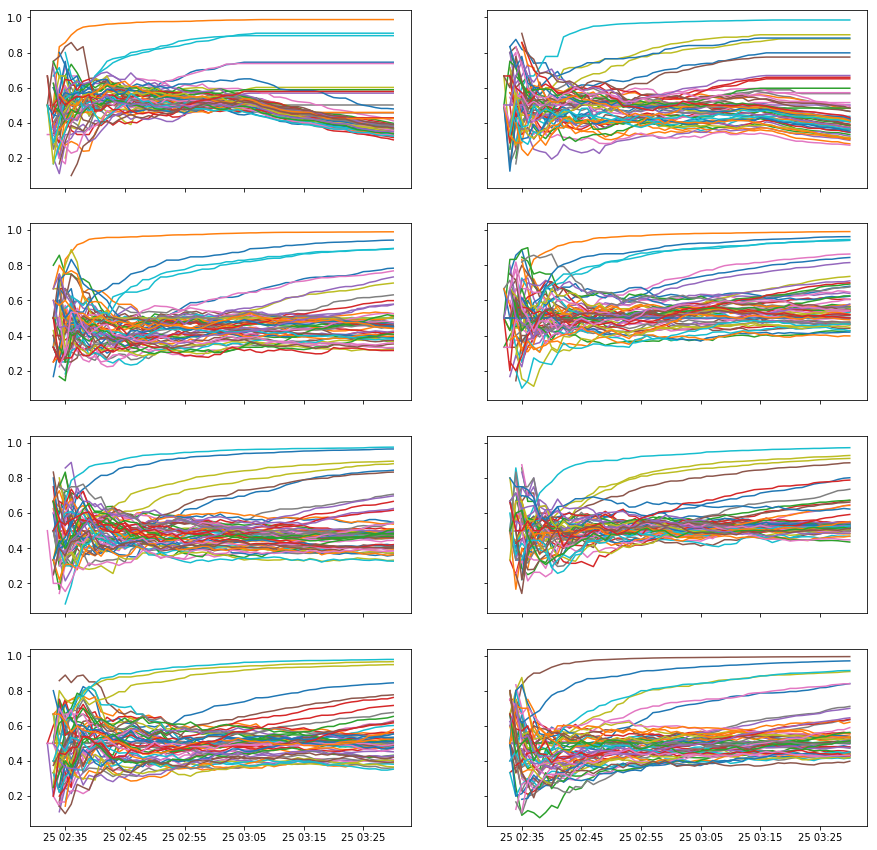

In [52]:
plot_endpoint_balances('Find', peers, peers)

#### observations: divergent request/response ratios
- not seen before, probably b/c number of total peers was relatively small
- possible explanations
    - now peers may be being dropped from routing table
    - peers may be queried less frequently and thus could quickly be buried in bucket ordering
- should see if can replicate divergence with 32 peers using 8-peer buckets (instead of 64 w/ 20-peer buckets)
- possible resolutions
    - bucket ordering uses latest response *or* request time (instead of just latest response time)
        - should try this first
    - change how bucket pop behaves
        - add healthy and good judge filters: only pop good, healthy peers
        - move to target-based popping: pop peers in bucket closest to target
            - makes popping more uniform across peers

## trial 05: 32 peers with 8 max peers per routing table bucket

In [41]:
peer_query_counts = load_peer_query_counts('../trial05/data/peer_query_count.json.gz')

32 peers, 5536 time series


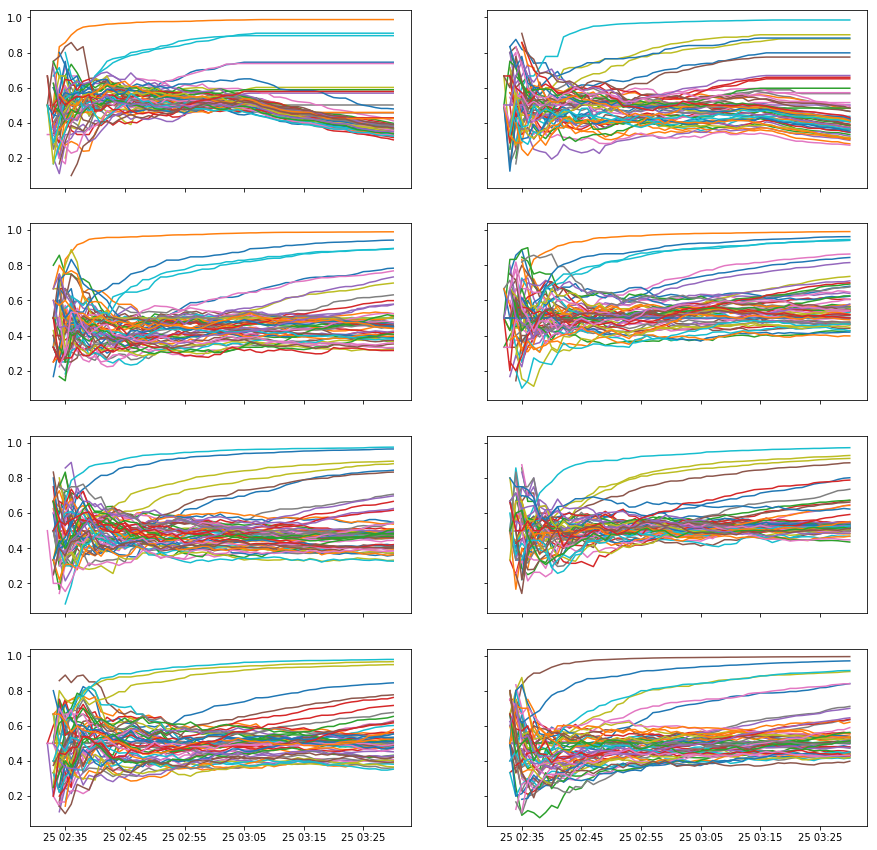

In [42]:
plot_endpoint_balances('Find', peers[:8], peers)

#### observations
- same divergent rq/rp ratios as in 64-peer trial04
    - most likely due to peers being evicted from routing buckets

## trial 06: same as trial 05 but with tweak to how peers are preferred
- [#184](https://github.com/drausin/libri/pull/184)
    - latest time with peer can come from either latest request or response
    - within minute, peers ordered by (request count - response count)

In [43]:
peer_query_counts = load_peer_query_counts('../trial06/data/peer_query_count.json.gz')

32 peers, 5609 time series


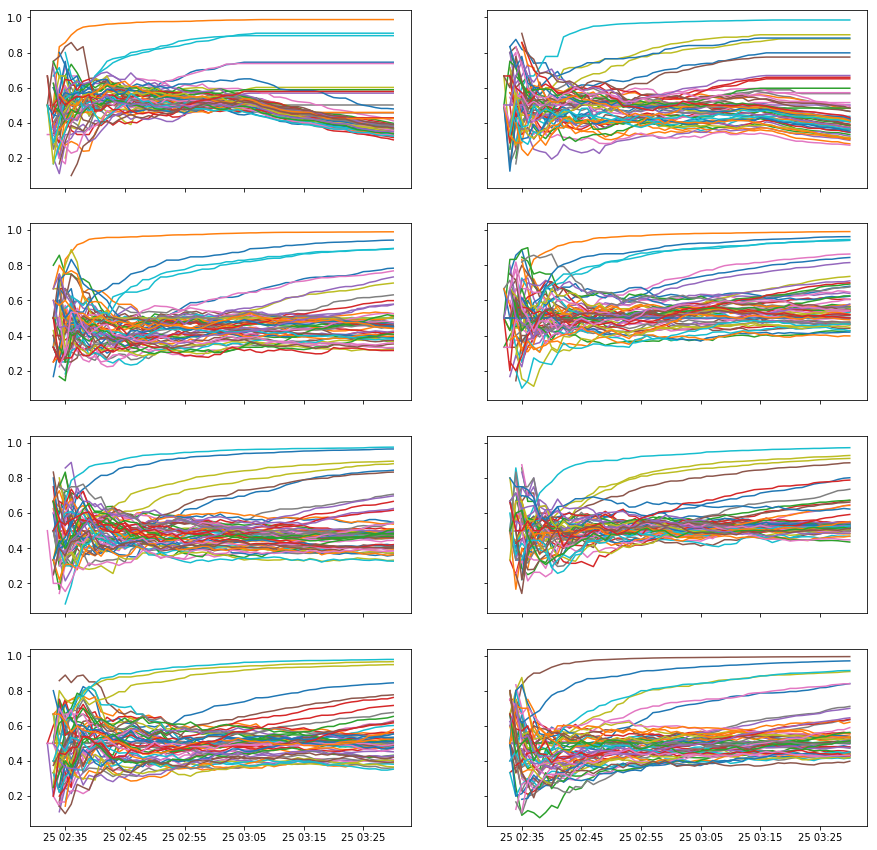

In [44]:
plot_endpoint_balances('Find', peers[:8], peers)

#### observations
- same issue as trial 05

## trial 07: routing bucket find + non-fixed membership
- commit [39e5717](https://github.com/drausin/libri/commit/39e5717e4abd29f288bfa4643e632532ce277349)

In [63]:
peer_query_counts = load_peer_query_counts('../trial07/data/peer_query_count.json.gz')

32 peers, 5515 time series


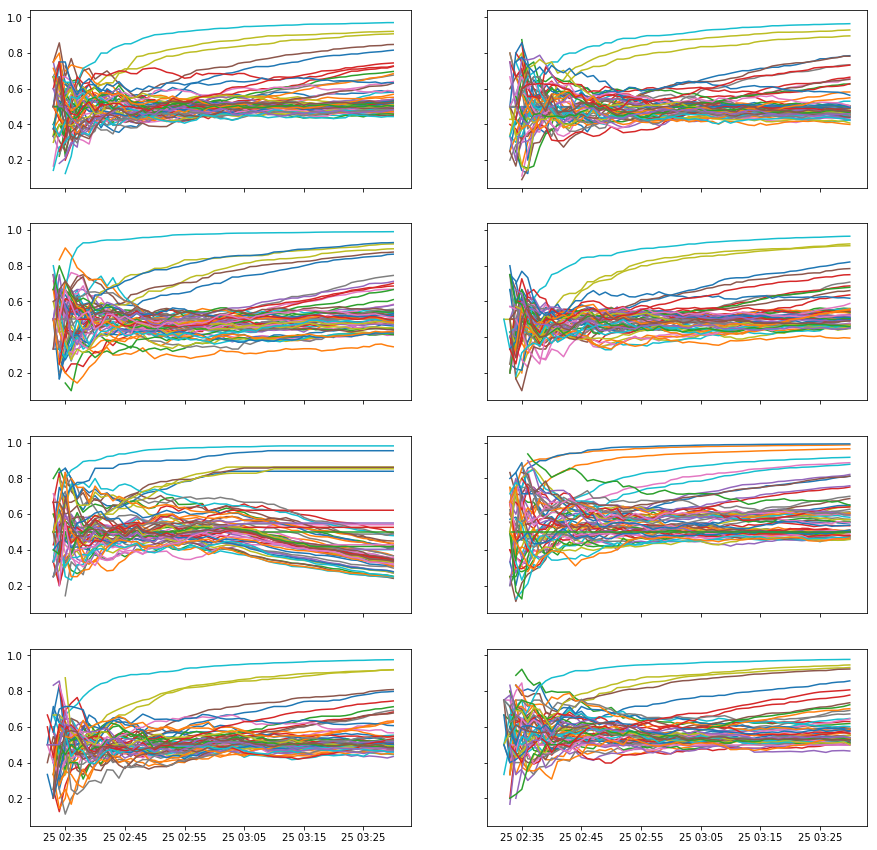

In [109]:
plot_endpoint_balances('Find', peers[16:24], peers)

#### observations
- no real change from prev trials
- since routing table find now returns peers closest to target, divergence seems to solely stem from peers being dropped from routing table

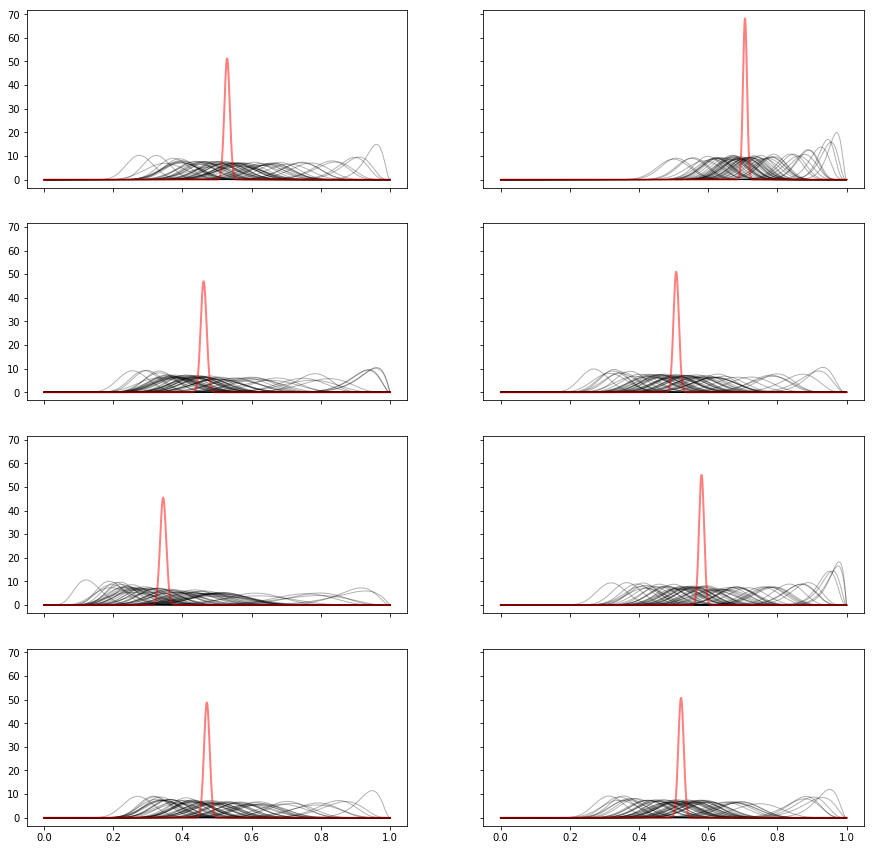

In [113]:
prior_a, prior_b = 1.1, 1.1
xs = np.linspace(0.0, 1.0, 1000)
endpoint = 'Store'

fig, axes = plt.subplots(ncols=2, nrows=4, sharey=True, sharex=True, figsize=(15,15))
for i, self in enumerate(peers[16:24]):
    x, y = int(i / 2), int(i % 2)
    rq_count_tot, rp_count_tot = 0, 0
    for j, other in enumerate(peers):
        rq_values = get_success_ts(result, self, other, endpoint, query_type='REQUEST')
        rp_values = get_success_ts(result, self, other, endpoint, query_type='RESPONSE')
        if rq_values is None or rp_values is None:
            continue
        rq_count, rp_count = rq_values[-1], rp_values[-1]
        rq_count_tot += rq_count
        rp_count_tot += rp_count
        axes[x, y].plot(xs, beta.pdf(xs, a + rq_count, b + rp_count), 'k-', lw=1, alpha=0.3)
    axes[x, y].plot(xs, beta.pdf(xs, a + rq_count_tot, b + rp_count_tot), 'r-', lw=2, alpha=0.5)

In [111]:
rq_values[-1], rp_values[-1]

(38, 25)